# Demo: Robust MNIST Classification
<hr />

This interactive notebook serves as a guide for training a robust MNIST classification network using the SABRE framework.

### Navigating to the Project Directory

In [1]:
cd ..

/mnt/cdtds_cluster_home/s1896334/Research/sabre



## Installing dependencies

Run the following command to install dependencies from the `requirements.txt` file:

In [2]:
pip install -r ./requirements.txt

  Cloning https://github.com/fbcotter/pytorch_wavelets to /tmp/pip-req-build-fwm8c8zh
  Running command git clone --filter=blob:none --quiet https://github.com/fbcotter/pytorch_wavelets /tmp/pip-req-build-fwm8c8zh
  Resolved https://github.com/fbcotter/pytorch_wavelets to commit 9a0c507f04f43c5397e384bb6be8340169b2fd9a
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/BorealisAI/advertorch to /tmp/pip-req-build-g6955rpk
  Running command git clone --filter=blob:none --quiet https://github.com/BorealisAI/advertorch /tmp/pip-req-build-g6955rpk
  Resolved https://github.com/BorealisAI/advertorch to commit e063e341c87d9a621ae1a8f72c3507d5ea5bd327
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-6y9q1fu0
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack /tmp/pip-req-build-6y9q1fu0
  Resolved https://github.com/fra31/auto-attack to commit a39220048b3c9f2cca9a4d3a54604793

Following the installation of dependencies, verify that PyTorch is correctly installed:

In [3]:
import torch
print("Torch version:", torch.__version__)
print("GPU count:", torch.cuda.device_count())

Torch version: 2.1.0+cu121
GPU count: 1


## Running experiments


### Setup
Setting up the experiments involves preparing the environment by importing necessary libraries, defining key parameters, and loading the dataset.

**Imports**

To begin, import essential Python libraries and modules that will be used throughout our experiments. This includes standard libraries such as os for file and directory operations, matplotlib.pyplot for plotting, and torch.nn.functional for neural network operations.

In [4]:
import os

root_path = "./"

from core.defenses.sabre import SabreWrapper
from core.attacks import EoTPGD

from datasets.mnist import get_mnist
from models.mnist import MNISTModel
from models.helpers import load_model
from experiments.utils import ceil_dec, sabre_train, evaluate
from experiments.setup import create_directories
from utils.log import printer

import matplotlib.pyplot as plt
import torch.nn.functional as F

This setup encompasses all necessary imports, from the core SABRE defense mechanism and EoT-PGD attack method, to utility functions that streamline the training and evaluation processes.

**Parameters**

Next, we define a set of parameters that will guide our experiments. These parameters capture everything from computational resource allocation (GPU or CPU) to the specifics of our model architecture and the adversarial context in which it will be trained and evaluated.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = "SABRE"
epsilon = ceil_dec(80. / 255, 3)
batch_size = 32
n_variants = 10
normalize = False
use_rand = True
run_auto_attack = False
run_transfer_attacks = False

dataset_name = "mnist"
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

n_channels = 1
learning_rate = 1e-2
plot_images_during_training = True

train_params = {
    "eps": epsilon,
    "n_channels": n_channels,
    "normalize": normalize,
    "learning_rate": learning_rate,
    "plot_images": plot_images_during_training
}

models_dir, logs_dir = create_directories(model_name, dataset_name)
records_file = os.path.join(logs_dir, "records.json")
traces_file = os.path.join(logs_dir, "traces.txt")
results_file = os.path.join(logs_dir, "results.txt")
model_path = f"{models_dir}/model.weights.pth"

Defining these parameters allows us to streamline the executions across different configuration scenarios, facilitating the comparison of results.

**Loading dataset**

We prepare both the training and validation datasets, and return DataLoaders with the specified batch size:

In [6]:
data_root = os.path.join(root_path, "datasets")
train_data_loader, test_data_loader = get_mnist(batch_size=batch_size, data_root=data_root,
                                                train=True, val=True, return_loader=True)

With our setup complete, we are now ready to proceed to the core of our experiments: training and evaluating our models under various conditions to assess the effectiveness of the SABRE framework in enhancing model robustness against adversarial attacks.

### Model definition
To create robust models, we define our classifier architecture and provide it to SABRE, with its configuration parameters defined earlier:

In [7]:
base_model = MNISTModel()
model = SabreWrapper(eps=epsilon, use_rand=use_rand, n_variants=n_variants, base_model=base_model)

### Training
During this phase, our goal is to develop a robust model capable of accurately classifying images from the CIFAR-10 dataset, even in the presence of adversarial attacks. Using our robust training function, we train the models over multiple epochs while meticulously logging progress, allowing us to monitor the model's evolving robustness and adjust parameters as needed to optimize performance.

In [8]:
if os.path.exists(model_path):
    printer(f'Model already exists: {model_path}\n', traces_file)
else:
    printer(f'Training model...\n', traces_file)

    model = sabre_train(model, train_data_loader, n_epochs=100, learning_rate=train_params["learning_rate"],
                        save_path=model_path, log_path=traces_file, params=train_params)

Model already exists: /mnt/cdtds_cluster_home/s1896334/Research/sabre/artifacts/saved_models/SABRE/mnist/model.weights.pth



### Evaluation
After training, the model undergoes a rigorous evaluation phase where it is exposed to various adversarial attack methods. In this instance, we assess the model's performance and robustness against the EoT-PGD attack — a potent variant of the Projected Gradient Descent attack enhanced with Expectation over Transformation (EoT).

**Loading the trained model**

In [9]:
model = load_model(model, model_path=model_path, log_path=traces_file)

Loading model weights from: /mnt/cdtds_cluster_home/s1896334/Research/sabre/artifacts/saved_models/SABRE/mnist/model.weights.pth


**Evaluating the benign accuracy**

In [10]:
printer(f'Evaluating model... [No Attack]\n', traces_file)

evaluate(model, attack=None, data_loader=test_data_loader, log_path=traces_file)

Evaluating model... [No Attack]

[Batch: 31 / 313] Accuracy: 99.194 (984/992)
[Batch: 62 / 313] Accuracy: 99.042 (1965/1984)
[Batch: 93 / 313] Accuracy: 98.891 (2943/2976)
[Batch: 124 / 313] Accuracy: 98.916 (3925/3968)
[Batch: 155 / 313] Accuracy: 98.931 (4907/4960)
[Batch: 186 / 313] Accuracy: 99.093 (5898/5952)
[Batch: 217 / 313] Accuracy: 99.078 (6880/6944)
[Batch: 248 / 313] Accuracy: 99.194 (7872/7936)
[Batch: 279 / 313] Accuracy: 99.261 (8862/8928)
[Batch: 310 / 313] Accuracy: 99.274 (9848/9920)
Finished Evaluation
Accuracy: 99.280 (9928/10000)


(9928, 10000)

**Evaluating the robustness against the adversarial attack**

In [11]:
attack = EoTPGD(eps=80./255, alpha=0.05, steps=7, eot_steps=10)
attack.set_model(model)

printer(f'Evaluating model... [Attack=EoT-PGD 7 steps]\n', traces_file)

evaluate(model, attack, test_data_loader, log_path=traces_file)

Evaluating model... [Attack=EoT-PGD 7 steps]

[Batch: 31 / 313] Accuracy: 99.899 (991/992)
[Batch: 62 / 313] Accuracy: 99.849 (1981/1984)
[Batch: 93 / 313] Accuracy: 99.798 (2970/2976)
[Batch: 124 / 313] Accuracy: 99.773 (3959/3968)
[Batch: 155 / 313] Accuracy: 99.738 (4947/4960)
[Batch: 186 / 313] Accuracy: 99.782 (5939/5952)
[Batch: 217 / 313] Accuracy: 99.784 (6929/6944)
[Batch: 248 / 313] Accuracy: 99.811 (7921/7936)
[Batch: 279 / 313] Accuracy: 99.832 (8913/8928)
[Batch: 310 / 313] Accuracy: 99.839 (9904/9920)
Finished Evaluation
Accuracy: 99.840 (9984/10000)


(9984, 10000)

### Visualization
To visually assess the robustness of our model, we compare the original images with their adversarial counterparts and the model's reconstructions that are fed to the classifiers.

Robust Accuracy: 100.00
Plotting results for 5 images...


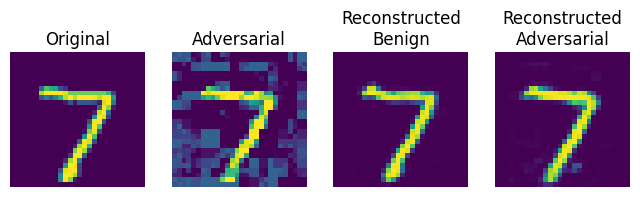

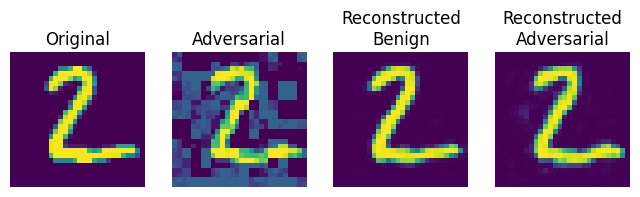

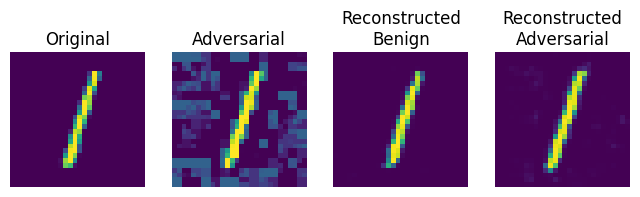

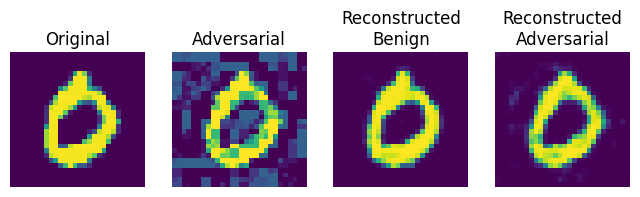

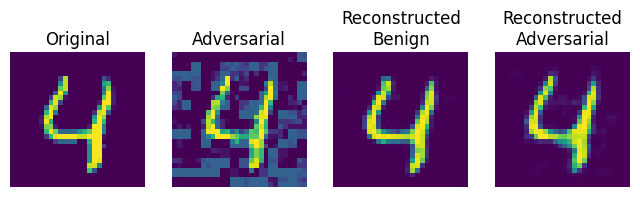

In [12]:
images, labels = next(iter(test_data_loader))
images, labels = images.to(device), labels.to(device)

with torch.enable_grad():
    adversarial_images = attack(images, labels).float()

reconstructed_benign = model.preprocessing(images)
reconstructed_adversarial = model.preprocessing(adversarial_images)

outputs_robust_adversarial = model.classify(reconstructed_adversarial)
_, predicted_robust_adversarial = outputs_robust_adversarial.max(1)

total = labels.size(0)
correct = predicted_robust_adversarial.eq(labels).sum().item()

print(f"Robust Accuracy: {100 * correct / total:.2f}")

print("Plotting results for 5 images...")
for i in range(5):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(images[i].cpu().detach().squeeze().numpy())
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(adversarial_images[i].cpu().detach().squeeze().numpy())
    plt.title('Adversarial')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(reconstructed_benign[i].cpu().detach().squeeze().numpy())
    plt.title('Reconstructed\nBenign')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(reconstructed_adversarial[i].cpu().detach().squeeze().numpy())
    plt.title('Reconstructed\nAdversarial')
    plt.axis('off')

    plt.show()

### AutoAttack Evaluation
Validation of the robust model's performance against AutoAttack.

**Importing AutoAttack**

In [13]:
from autoattack import AutoAttack

**Preparing the dataset and model**

In [14]:
test_data_loader_all = get_mnist(batch_size=len(test_data_loader) * batch_size, data_root=data_root,
                                 train=False, val=True, return_loader=True)
x_all, y_all = next(iter(test_data_loader_all))

model.to(device)
model.eval()

SabreWrapper(
  (core): Sabre(
    (fwt): DWTForward()
    (iwt): DWTInverse()
  )
  (base_model): MNISTModel(
    (classifier): LeNetModel(
      (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (fc1): Linear(in_features=256, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=84, bias=True)
      (fc3): Linear(in_features=84, out_features=10, bias=True)
    )
    (denoise): DenoisingCNN(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(11, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=0.0001, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


**Evaluating the robustness against the adversarial attack**

* AutoAttack with epsilon = 80/255

In [15]:
print("Evaluating model... [Attack=AutoAttack, eps=80/255]\n")
adversary = AutoAttack(model, norm='Linf', eps=80./255, version='rand', verbose=True,
                       log_path=traces_file, device=device)
_ = adversary.run_standard_evaluation(x_all, y_all, bs=256)

Evaluating model... [Attack=AutoAttack, eps=80/255]

setting parameters for rand version
using rand version including apgd-ce, apgd-dlr.
initial accuracy: 99.33%
apgd-ce - 1/39 - 0 out of 256 successfully perturbed
apgd-ce - 2/39 - 1 out of 256 successfully perturbed
apgd-ce - 3/39 - 1 out of 256 successfully perturbed
apgd-ce - 4/39 - 1 out of 256 successfully perturbed
apgd-ce - 5/39 - 1 out of 256 successfully perturbed
apgd-ce - 6/39 - 2 out of 256 successfully perturbed
apgd-ce - 7/39 - 1 out of 256 successfully perturbed
apgd-ce - 8/39 - 1 out of 256 successfully perturbed
apgd-ce - 9/39 - 1 out of 256 successfully perturbed
apgd-ce - 10/39 - 2 out of 256 successfully perturbed
apgd-ce - 11/39 - 1 out of 256 successfully perturbed
apgd-ce - 12/39 - 1 out of 256 successfully perturbed
apgd-ce - 13/39 - 1 out of 256 successfully perturbed
apgd-ce - 14/39 - 0 out of 256 successfully perturbed
apgd-ce - 15/39 - 2 out of 256 successfully perturbed
apgd-ce - 16/39 - 1 out of 256 succes

* AutoAttack with epsilon = 150/255

In [16]:
print("Evaluating model... [Attack=AutoAttack, eps=150/255]\n")
adversary = AutoAttack(model, norm='Linf', eps=150./255, version='rand', verbose=True,
                       log_path=traces_file, device=device)
_ = adversary.run_standard_evaluation(x_all, y_all, bs=256)

Evaluating model... [Attack=AutoAttack, eps=150/255]

setting parameters for rand version
using rand version including apgd-ce, apgd-dlr.
initial accuracy: 99.67%
apgd-ce - 1/39 - 28 out of 256 successfully perturbed
apgd-ce - 2/39 - 35 out of 256 successfully perturbed
apgd-ce - 3/39 - 32 out of 256 successfully perturbed
apgd-ce - 4/39 - 39 out of 256 successfully perturbed
apgd-ce - 5/39 - 37 out of 256 successfully perturbed
apgd-ce - 6/39 - 42 out of 256 successfully perturbed
apgd-ce - 7/39 - 40 out of 256 successfully perturbed
apgd-ce - 8/39 - 32 out of 256 successfully perturbed
apgd-ce - 9/39 - 30 out of 256 successfully perturbed
apgd-ce - 10/39 - 34 out of 256 successfully perturbed
apgd-ce - 11/39 - 43 out of 256 successfully perturbed
apgd-ce - 12/39 - 41 out of 256 successfully perturbed
apgd-ce - 13/39 - 37 out of 256 successfully perturbed
apgd-ce - 14/39 - 26 out of 256 successfully perturbed
apgd-ce - 15/39 - 32 out of 256 successfully perturbed
apgd-ce - 16/39 - 27 

## Conclusion
This notebook, through the processes of training, evaluation, and visualization of MNIST within the context of adversarial robustness, effectively demonstrates the effectiveness of the SABRE framework and provides a high-level overview of of how it can be used to enhance the resilience of machine learning models against adversarial attacks.